# 2. Feature SelectionModel
Author: _Carlos Sevilla Salcedo (Updated: 18/07/2019)_

In this notebook we are going to present the extension to include a double sparsity in the model. The idea behind this modification is that besides imposing sparsity in the latent features, we could also force to have sparsity in the input features. This way, the model is capable of not only inferring any data desired, but also carry out a feature selection with a measure of the importance of each feature.

The main advantage of this characteristic is two-fold: 1) It allows us to work with lower dimension matrices which, in return, improves the speed of the results. 2) It provides a selection of the most important features which in certain scenarios can considerably improve the interpretability of the results.

## Synthetic data generation

We can now generate data in a similar manner to the regression model to compare the performance of both apporaches. In this case we are going to include some random features to try to suppress them with the sparse model.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
np.random.seed(0)

N = 1000  # number of samples
D0 = 55  # input features
D1 = 3   # output features

myKc = 20

K = 2       # common latent variables
K0 = 3      # first view's latent variables
K1 = 3      # second view's latent variables
Kc=K+K0+K1  # latent variables

# Generation of matrix W
A0 = np.random.normal(0.0, 1, D0 * K).reshape(D0, K)
A1 = np.random.normal(0.0, 1, D1 * K).reshape(D1, K)

B0 = np.random.normal(0.0, 1, D0 * K0).reshape(D0, K0)
B1 = np.random.normal(0.0, 1, D1 * K1).reshape(D1, K1)

W0 = np.hstack((np.hstack((A0,B0)),np.zeros((D0,K1))))
W1 = np.hstack((np.hstack((A1,np.zeros((D1,K0)))),B1))
W_tot = np.vstack((W0,W1))

# Generation of matrix Z
Z = np.random.normal(0.0, 1, Kc * N).reshape(N, Kc)

# Generation of matrix X
X0 = np.dot(Z,W0.T) + np.random.normal(0.0, 0.1, D0 * N).reshape(N, D0)
X1 = np.dot(Z,W1.T) + np.random.normal(0.0, 0.1, D1 * N).reshape(N, D1)

#Random features generation
DN0 = 300
X0  = np.hstack((X0,np.random.normal(0.0, 0.1, DN0 * N).reshape(N,DN0)))

Once the data is generated we divide it into train and test in order to be able to test the performance of the model. After that, we can normalize the data.

In [2]:
from sklearn.model_selection import train_test_split
X_tr, X_tst, Y_tr, Y_tst = train_test_split(X0, X1, test_size=0.3, random_state = 31)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_tr = scaler.fit_transform(X_tr)
X_tst = scaler.transform(X_tst)

## Training the model

Once the data is prepared we just have to feed it to the model. As the model has so many possibilities we have decided to pass the data to the model following a particular structure so that we can now, for each view, if the data corresponds to real, multilabel or categorical as well as knowing if we want to calculate the model with sparsity in the features.

In this case we are indicating we want to prune the latent features, so that if a latent feature has a sufficiently low value for all the features in matrix $W$, this latent feature will be eliminated.

In [3]:
import os
os.sys.path.append('lib')
import sshiba

In [4]:
myKc = 20            # number of latent features
max_it = int(5*1e4)  # maximum number of iterations
tol = 1e-6           # tolerance of the stopping condition (abs(1 - L[-2]/L[-1]) < tol)
prune = 1            # whether to prune the irrelevant latent features

myModel = sshiba.SSHIBA(myKc, prune)
X0_tr = myModel.struct_data(X_tr, 0, 1)
X1_tr = myModel.struct_data(Y_tr, 0, 0)
X0_tst = myModel.struct_data(X_tst, 0, 0)
X1_tst = myModel.struct_data(Y_tst, 0, 0)
myModel.fit(X0_tr, X1_tr, max_iter = max_it, tol = tol, Y_tst = X1_tst, X_tst = X0_tst, mse = 1)
print('Final MSE %.3f' %(myModel.mse[-1]))

Iteration 1620 Lower Bound 473636.1 K    9
Model correctly trained. Convergence achieved
Final L(Q):    473636.1
Final MSE 9.493


## Visualization of the results

### Lower Bound and MSE

Now the model is trained we can plot the evolution of the lower bound through out the iterations. This lower bound is calculated using the values of the variables the model is calculating and is the value we are maximizing. As we want to maximize this value it has to be always increasing with each iteration.

At the same time, we are plotting now the evolution of the Minimum Square Error (MSE) with each update of the model. As we are not minimizing this curve, this doesn't necessarily have to be always decreasing and might need more iterations to reach a minimum. 

In [5]:
def plot_mse(mse):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(mse, linewidth=2, marker='s',markersize=5, label='SSHIBA', markerfacecolor='red')
    ax.grid()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('MSE')
    plt.legend()

def plot_L(L):
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(L, linewidth=2, marker='s',markersize=5, markerfacecolor='red')
    ax.grid()
    ax.set_xlabel('Iteration')
    ax.set_ylabel('L(Q)')
    
def plot_W(W):
    plt.figure()
    plt.imshow((np.abs(W)), aspect=W.shape[1]/W.shape[0])
    plt.colorbar()
    plt.title('W')
    plt.ylabel('features')
    plt.xlabel('K')

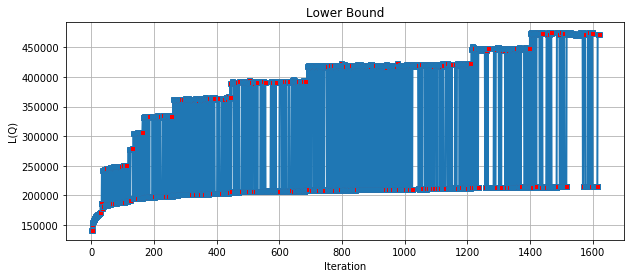

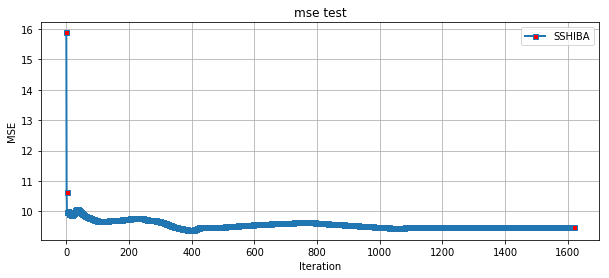

In [6]:
plot_L(myModel.L)
plt.title('Lower Bound')

plot_mse(myModel.mse)
plt.title('mse test')
plt.show()

### Sparsity in matrix W

For the sake of this example the model has not been automatically erasing a feature whenever it is considered as irrelevant and, instead of deleting it the model has just learned that these features are less important.

As we now have the different weights given to each feature based on their relevance, we can now determine whether the algorithm has been capable of determining which features are relevant or not. To do so, we are going to start by showing the values of the learnt variable $\gamma$ which tole is to force sparsity in the feature space.

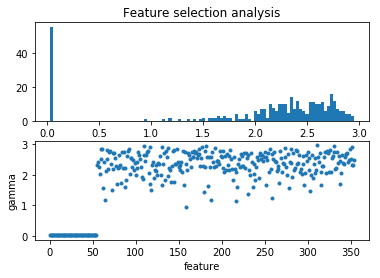

In [7]:
q = myModel.q_dist
gamma = q.gamma_mean(0)

ax1 = plt.subplot(2, 1, 1)
plt.title('Feature selection analysis')
plt.hist(gamma,100)
ax2 = plt.subplot(2, 1, 2)
plt.plot(gamma,'.')
plt.ylabel('gamma')
plt.xlabel('feature')
plt.show()

As we can see, the values that we have randomly added to the original data are recognisible and can be therefore easily selected as relevant. We can also see the efect of the sparsity by looking at matrix $W$ where the features that are found to be irrelevant have lower values than the ones which are relevant.

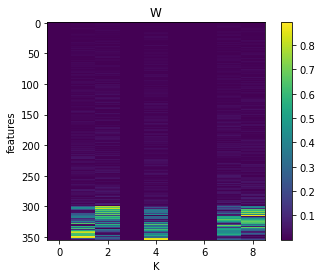

In [8]:
pos_ord_var=np.argsort(gamma)[::-1]
plot_W(q.W[0]['mean'][pos_ord_var,:])